In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn import GELU
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import bisect

In [2]:
# Prepare the Data ---------------------------------------------------------------------

# ------------------------
# Load info
# ------------------------
info_df = pd.read_csv("info.csv")
fs = info_df.iloc[0, 5]                  # sampling frequency (Hz)

# ------------------------
# Load baseline data
# ------------------------
baseline_df = pd.read_csv("baselinedataraw.csv")
baseline_time = baseline_df.iloc[:, 0].values            # time column (seconds)
baseline_data = baseline_df.iloc[:, 1:].values           # data columns

# ------------------------
# Load main data
# ------------------------
df = pd.read_csv("dataraw.csv")
time = df.iloc[:, 0].values            # time column (seconds)
data = df.iloc[:, 1:].values           # data columns

# ------------------------
# Load events
# ------------------------
events_df = pd.read_csv("events.csv")
event_times = events_df.iloc[:, 0].values  # assume first column is event time in seconds
event_times = np.sort(event_times)         # ensure sorted

# For fast lookup using binary search
def count_events_in_window(t, window=0.2):
    """
    Count how many event_times fall in (t - window, t].
    Uses bisect for O(log n) search.
    """
    left = bisect.bisect_right(event_times, t - window)
    right = bisect.bisect_right(event_times, t)
    return right - left

# ------------------------
# Compute event count for each row
# ------------------------
event_counts = np.array([count_events_in_window(t, 1.2/fs) for t in time])
event_counts = event_counts.reshape(-1, 1)

# Append event_counts as an additional input feature
data_aug = np.hstack([data, event_counts])
# Now each input row has: [original data..., event_count]

# ------------------------
# Build input-output pairs using the _ ms rule
# ------------------------
dt_target = 1/fs      # s
dt_tol = 0.15 * dt_target
drow_target = int(dt_target * fs)  # number of rows 
seq_len = 64                   # samples

X_list = []
Y_list = []

# create sliding windows
def create_windows(data, seq_len=128, horizon=1):
    X, Y = [], []
    for i in range(len(data) - seq_len - horizon + 1):
        X.append(data[i:i+seq_len])
        Y.append(data[i+seq_len + horizon - 1])
    return np.array(X), np.array(Y)

# --- baseline data ---
Nbl = len(baseline_df)
inputs = []
for i in range(Nbl - drow_target):
    dt = baseline_time[i+drow_target] - baseline_time[i]
    if abs(dt - dt_target) <= dt_tol:
        inputs.append(baseline_data[i]) 
    else:
        x, y = create_windows(inputs, seq_len, drow_target)
        if x is not None:
            X_list.append(x)
            Y_list.append(y)
        inputs = []
# catch trailing segment
x, y = create_windows(inputs, seq_len, drow_target)
if x is not None:
    X_list.append(x)
    Y_list.append(y)

X = np.concatenate(X_list, axis=0)
Y = np.concatenate(Y_list, axis=0)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

print("Pairs created:", len(X))
print("Input shape :", X.shape)   
print("Output shape:", Y.shape)

num_feat = X.shape[-1]

# -----------------------------------------------------------------------------------------------


Pairs created: 1439935
Input shape : torch.Size([1439935, 64, 7])
Output shape: torch.Size([1439935, 7])


In [3]:
# define NN architecture

class TimeSeriesTransformer(nn.Module):
    def __init__(self, dim_in, dim_model=64, num_heads=4, num_layers=4, dim_ff=128, pos_len=512):
        super().__init__()

        # Project inputs into model dimension
        self.input_proj = nn.Linear(dim_in, dim_model)

        # Positional encoding
        self.pos_emb = nn.Parameter(torch.randn(1, pos_len, dim_model))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_model,
            nhead=num_heads,
            dim_feedforward=dim_ff,
            batch_first=True  # lets inputs be (B, T, D)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output head for next-step prediction
        self.fc_out = nn.Linear(dim_model, dim_in)
        # TO DO: try changing this to direct one-shot K-step prediction

    def forward(self, x):
        """
        x: (B, T, dim_in)
        """
        if x.ndim != 3:
            raise ValueError(f"Expected input ndim=3, got {x.ndim}")
        T = x.size(1)
        if T > self.pos_emb.size(1):
            raise RuntimeError(f"Sequence length T={T} exceeds pos_len={self.pos_emb.size(1)}. "
                               "Either increase pos_len or ensure inputs have smaller T.")
        x = self.input_proj(x) + self.pos_emb[:, :T, :]
        z = self.encoder(x)
        out = self.fc_out(z[:, -1])  # decode final token
        return out


In [4]:
# Initialize the Model, Loss Function, and Optimizer

test_size=0.5
batch_size = 32

model = TimeSeriesTransformer(dim_in=num_feat, dim_model=50, num_heads=2, num_layers=2, dim_ff=64, pos_len=seq_len)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train / test
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size, random_state=42)
train_N = int((1 - test_size) * len(X))
X_train = X[:train_N]
Y_train = Y[:train_N]
X_test = X[train_N:]
Y_test = Y[train_N:]

# Create TensorDatasets
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
all_loader = DataLoader(TensorDataset(X, Y), shuffle=False)

In [5]:
# data baseline characteristics as reference for loss 
mean_y = Y_train.mean(dim=0)
std_y = Y_train.std(dim=0)
var_y = std_y ** 2
var_per_feat = np.var(Y_train.numpy(), axis=0)  # redundant?

Train samples: 719967
Batch size: 32
Batches/epoch: 22499
Epoch 1/1 — train_loss: 1243.789552, val_loss: 1159.225036


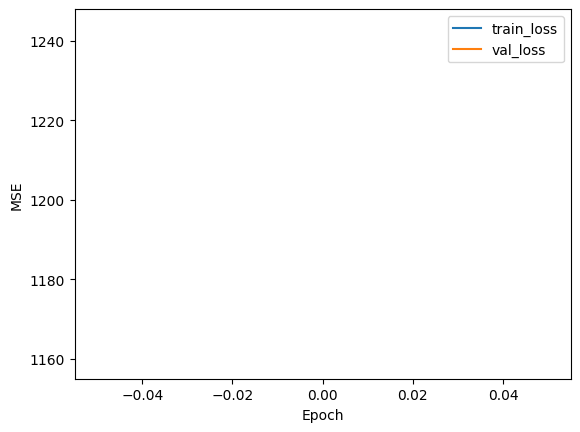

In [6]:
# Step 4: Train the Model
train_size = len(train_loader.dataset)
steps_per_epoch = math.ceil(train_size / batch_size)
print("Train samples:", train_size)
print("Batch size:", batch_size)
print("Batches/epoch:", steps_per_epoch)

model.train()
num_epochs = 1 # max
patience = 10
best_val = float('inf')
no_improve = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch in train_loader:
        # Forward pass
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / train_size
    train_losses.append(epoch_train_loss)

    # --- validate ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for X_val, Y_val in test_loader:   # use test_loader or a separate val_loader
            Y_val_pred = model(X_val)
            l = criterion(Y_val_pred, Y_val)
            val_running += l.item() * X_val.size(0)
    epoch_val_loss = val_running / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — train_loss: {epoch_train_loss:.6f}, val_loss: {epoch_val_loss:.6f}")

    # --- Early stopping ---
    if epoch_val_loss < best_val - 1e-9:
        best_val = epoch_val_loss
        no_improve = 0
        # Optionally save best model:
        # torch.save(model.state_dict(), "neural_network_pytorch.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"No improvement for {patience} epochs — stopping early at epoch {epoch+1}.")
            break

# After loop: plot train/val loss to inspect convergence
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [7]:
# load best model
# model.load_state_dict(torch.load("neural_network_pytorch.pth"))

Test Loss: 1159.2250


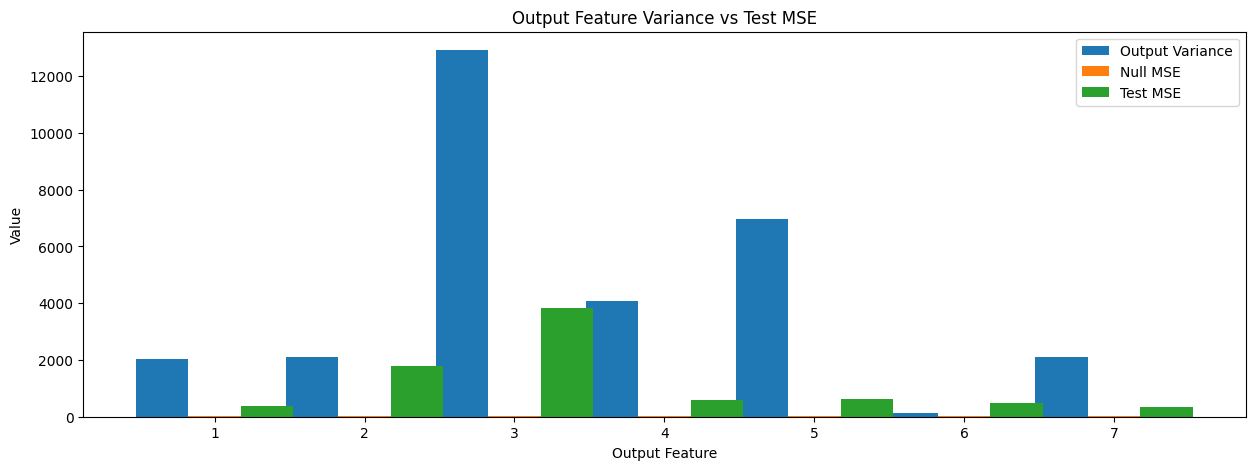

In [12]:
# Step 5: Evaluate the Model on Test Data

Y_pred = []

model.eval()
with torch.no_grad():
    total_loss = 0
    for x_batch, y_batch in test_loader:
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # sum up batch loss
        Y_pred.append(y_pred)

    avg_loss = total_loss / len(test_dataset)
    print(f"Test Loss: {avg_loss:.4f}")

Y_pred_np = np.array(Y_pred)
Y_pred_np = Y_pred_np.reshape(-1, num_feat)
Y_test_np = Y_test.numpy()

Y_null_all_np = X.numpy()[:, -1, :Y.shape[1]]
Y_null_test_np = X_test.numpy()[:, -1, :Y.shape[1]]

MSE_per_feat = np.mean((Y_test_np - Y_pred_np) ** 2, axis=0)
MSE_per_feat_null = np.mean((Y_test_np - Y_null_test_np) ** 2, axis=0)
feats = np.arange(1, Y.shape[1]+1)
barwid = .35

plt.figure(figsize=(15,5))
plt.bar(feats - barwid, var_per_feat, width=barwid, label='Output Variance')
plt.bar(feats, MSE_per_feat_null, width=barwid, label='Null MSE')
plt.bar(feats + barwid, MSE_per_feat, width=barwid, label='Test MSE')
plt.xlabel('Output Feature')
plt.ylabel('Value')
plt.title('Output Feature Variance vs Test MSE')
plt.legend()
plt.show()

In [13]:
X_all_np = X.numpy()
Y_all_np = Y.numpy()

Y_all_pred = []

model.eval()
with torch.no_grad():
    total_loss = 0
    for x_batch, y_batch in all_loader:
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # sum up batch loss
        Y_all_pred.append(y_pred)

    avg_loss = total_loss / len(test_dataset)
    print(f"Test+Train Loss: {avg_loss:.4f}")

Y_pred_all_np = np.array(Y_all_pred)
Y_pred_all_np = Y_pred_all_np.reshape(-1, num_feat)

Test+Train Loss: 1310.7185


In [14]:
# simulations 
simdur = int(0.2 * fs) # samples 
plotdomain = 1000 * np.array([-1, 1]) + train_N

Ysim = []
i0 = plotdomain[0]
model.eval()
while i0+simdur < plotdomain[1]:
    xi = torch.tensor(X_all_np[i0, :, :].reshape(1,-1,num_feat), dtype=torch.float32)
    for i in range(simdur):
        with torch.no_grad():
            yi = model(xi).numpy().flatten()
        Ysim.append(yi)
        # prepare next input
        if i < simdur - 1:
            #event_count_next = X_all_np[i0 + i + 1, -1]  # keep using original event count
            #xi = torch.tensor(np.hstack([yi, event_count_next]).reshape(1, -1), dtype=torch.float32)
            xi = torch.tensor(np.vstack([xi[0, 1:, :], yi]).reshape(1,-1,X.shape[-1]), dtype=torch.float32)
    i0 += simdur
    print("Simulating:", (i0-plotdomain[0])/(plotdomain[1]-plotdomain[0]), " complete." )

Ysim = np.array(Ysim)
plotxval = np.arange(len(Ysim)) + plotdomain[0]

Simulating: 0.1  complete.
Simulating: 0.2  complete.
Simulating: 0.3  complete.
Simulating: 0.4  complete.
Simulating: 0.5  complete.
Simulating: 0.6  complete.
Simulating: 0.7  complete.
Simulating: 0.8  complete.
Simulating: 0.9  complete.


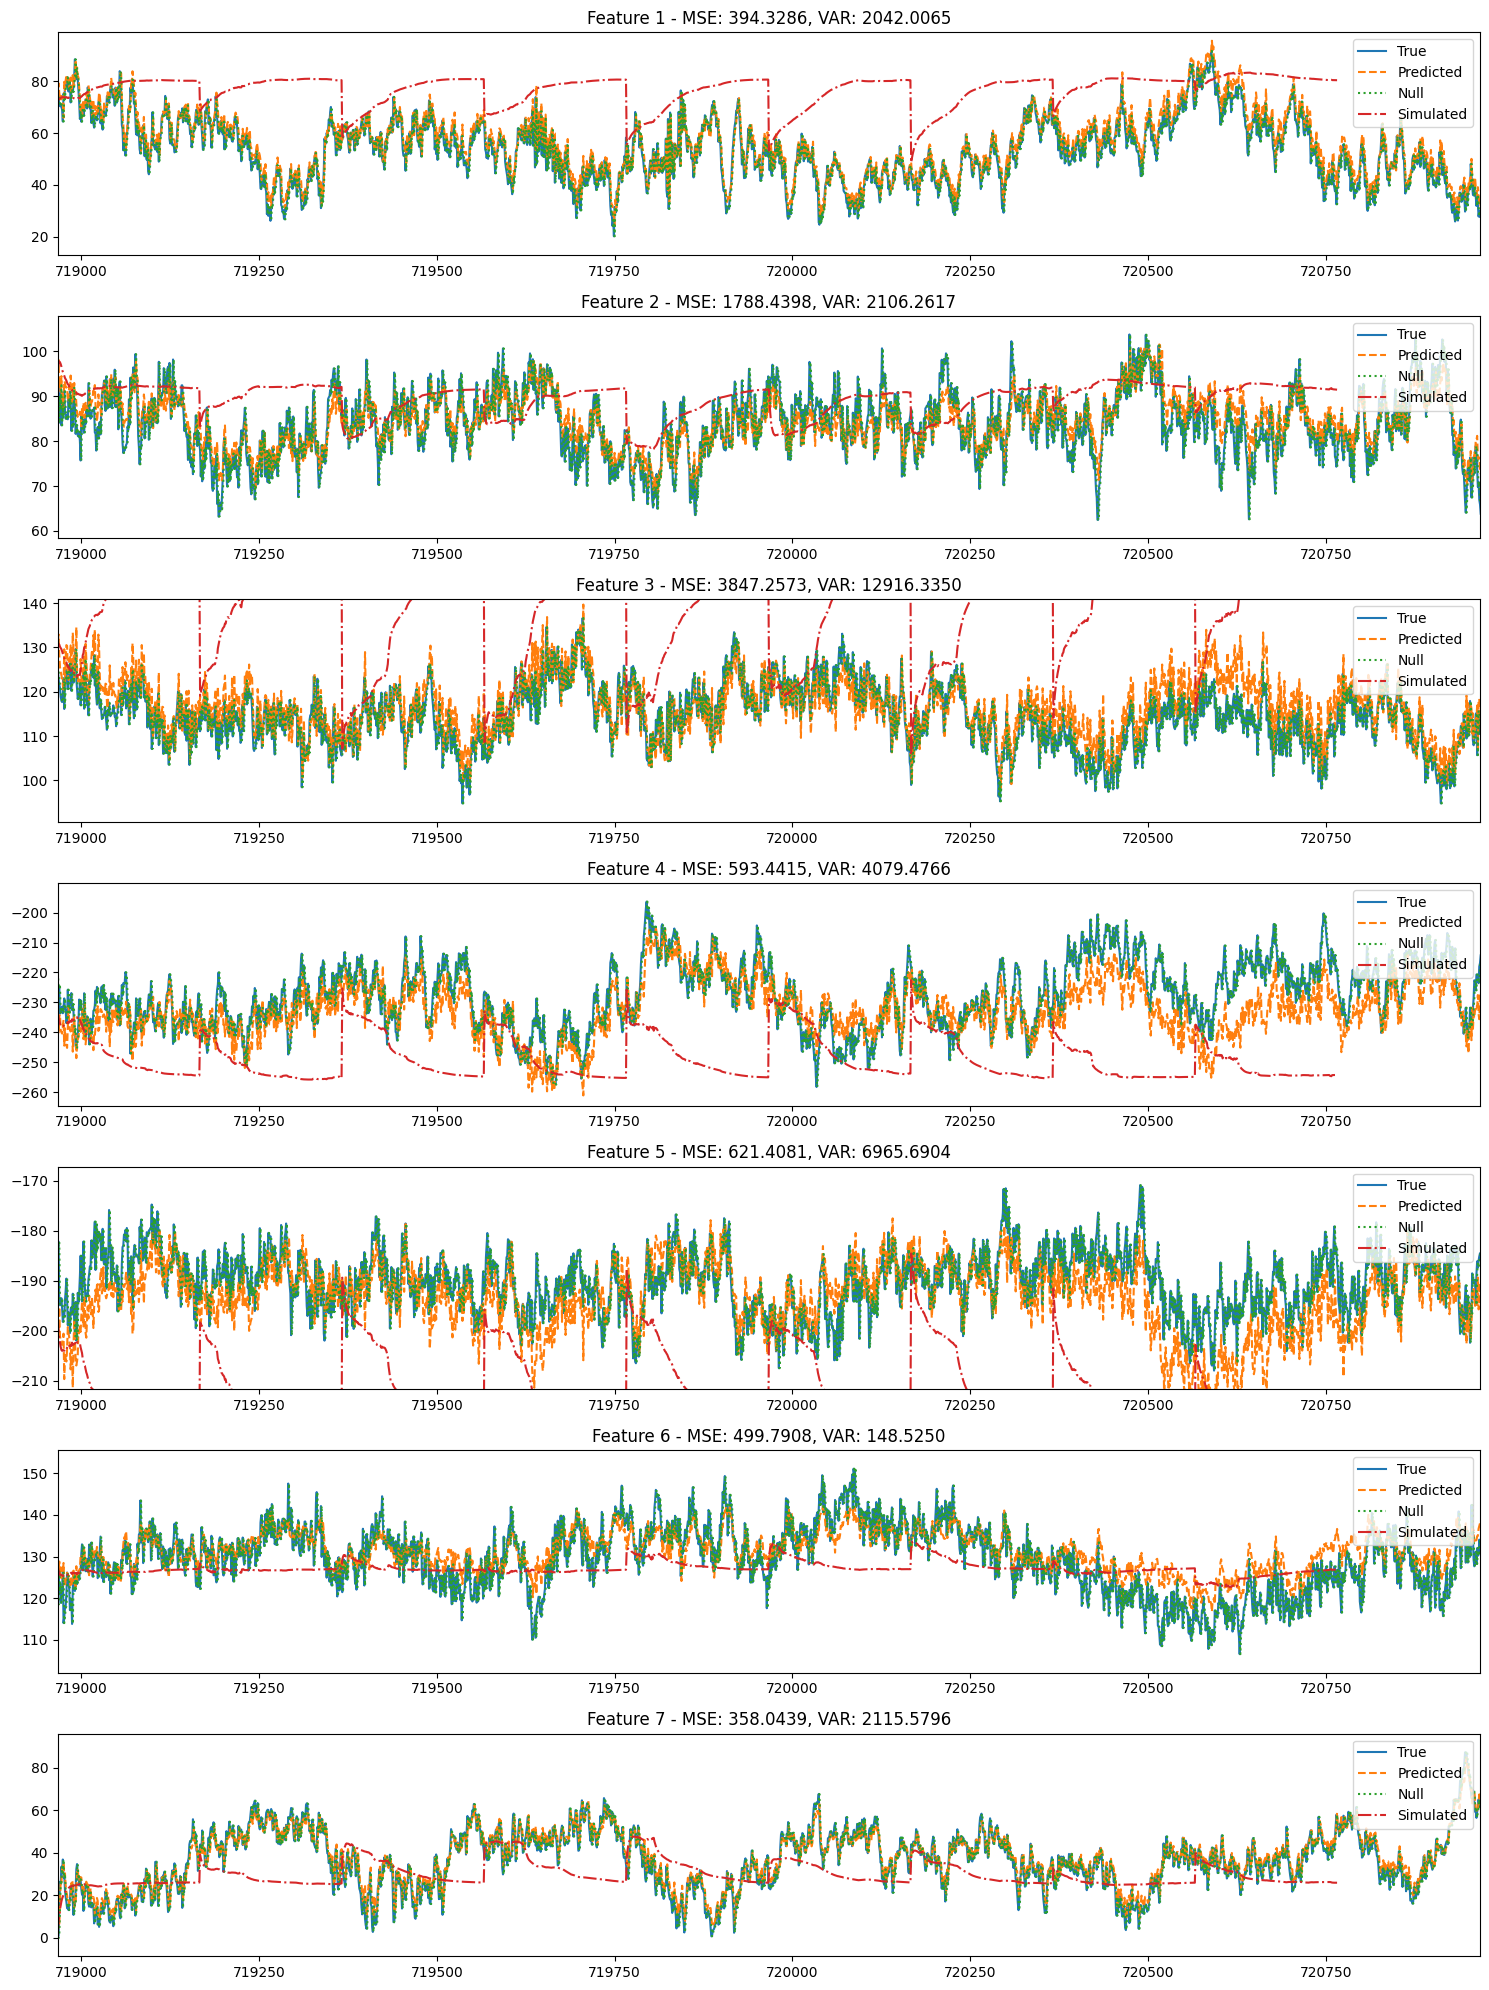

In [15]:
# show several examples 

iMSE = np.argsort(MSE_per_feat)
iVAR = np.argsort(var_per_feat)
iLRN = np.argsort(MSE_per_feat / var_per_feat)
iToPlot = [iMSE[:2], iMSE[-2:], iVAR[:2], iVAR[-2:], iLRN[:2], iLRN[-2:]]
iToPlot = list(set([i for sublist in iToPlot for i in sublist]))

plt.figure(figsize=(15,20))
iPlot = 1
for i in iToPlot:
    plt.subplot(len(iToPlot), 1, iPlot)
    plt.plot(Y_all_np[:, i], label='True')
    plt.plot(Y_pred_all_np[:, i], label='Predicted', linestyle='--')
    plt.plot(Y_null_all_np[:, i], label='Null', linestyle=':')
    plt.plot(plotxval, Ysim[:,i], label='Simulated', linestyle='-.')
    plt.xlim(plotdomain)

    # set the y limits to be slightly larger than the min/max of true values in the plotdomain
    y_min = np.min(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_max = np.max(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    plt.title(f'Feature {i+1} - MSE: {MSE_per_feat[i]:.4f}, VAR: {var_per_feat[i]:.4f}')
    plt.legend(loc='upper right')
    iPlot += 1
plt.tight_layout()
plt.show()